# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [ ]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [ ]:
import os
#import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

NameError: ignored

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    #torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    #torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

Выпишем все классы для последующего использования.

In [ ]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "fbcd3febb7d026a9780ae1b4249632a576590154"# вписать свой API Wandb
  project = "DL-2_homework"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "michaelbokov"# ввести свой логин
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  classes = {'T-shirt/top':0,'Trouser':1,'Pullover':2,'Dress':3,'Coat':4,'Sandal':5,
             'Shirt':6,'Sneaker':7,'Bag':8,'Ankle boot':9,}# ВАШ КОД ЗДЕСЬ # классы датасета
  wandb = True # флаг использования Wandb


In [ ]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [ ]:
class2dict(CFG)

{'api': 'fbcd3febb7d026a9780ae1b4249632a576590154',
 'classes': {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9},
 'entity': 'michaelbokov',
 'lr': 0.001,
 'num_epochs': 10,
 'num_workers': 4,
 'project': 'DL-2_homework',
 'seed': 2022,
 'test_batch_size': 512,
 'train_batch_size': 64,
 'wandb': True}

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [ ]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.2859,), (0.3530,))])

In [ ]:
datasets

<module 'torchvision.datasets' from '/usr/local/lib/python3.10/dist-packages/torchvision/datasets/__init__.py'>

Загружаем данные.

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)


test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

NameError: ignored

In [ ]:
!nvidia-smi

Wed May 24 23:31:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

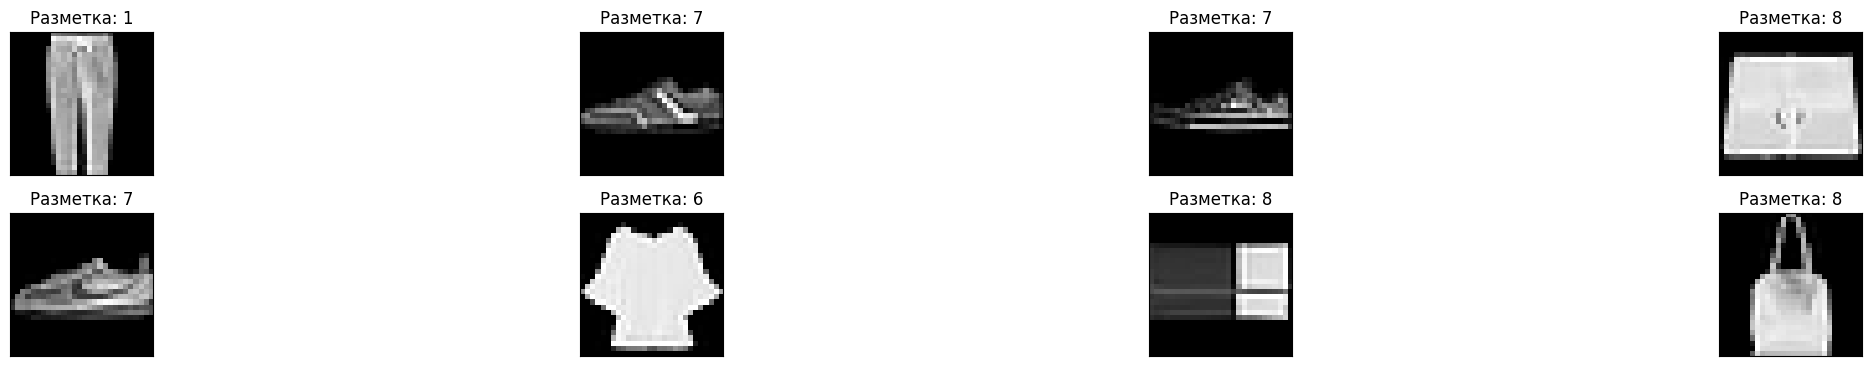

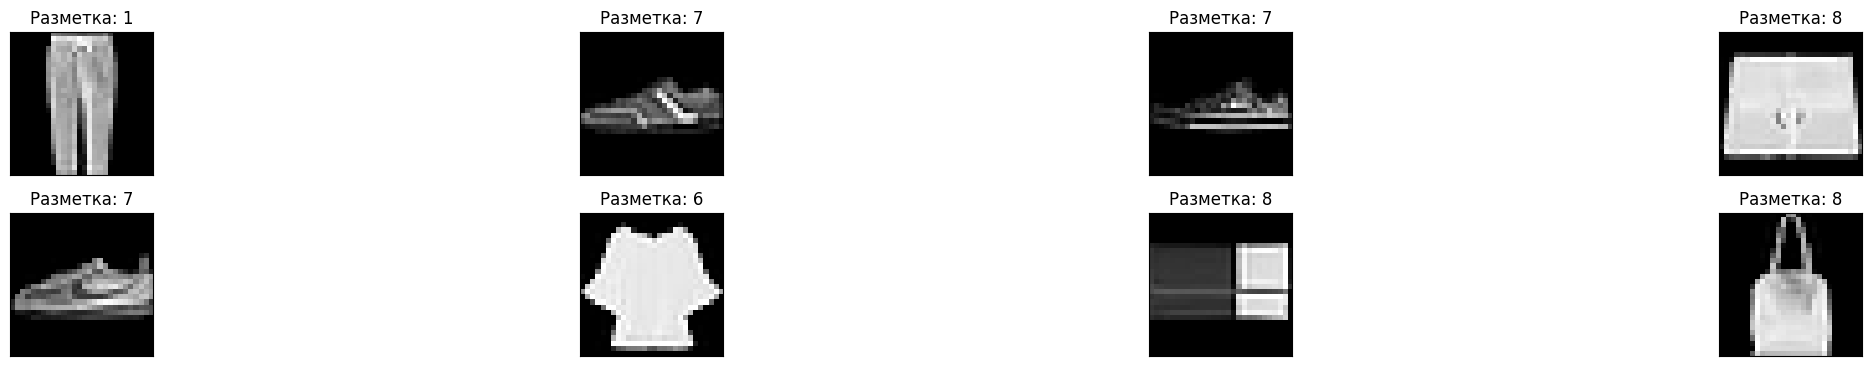

In [ ]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(8):
  plt.subplot(2,4,idx+1) # отрисуем 16 картинок
  plt.tight_layout()
  plt.imshow(images[idx][0], cmap='gray', interpolation='none')
  plt.title("Разметка: {}".format(labels[idx]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
images[0][0]

Создаем полносвязаннную нейронную сеть.

In [ ]:
class My_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self,
                 batchnorm=False,
                 dropout=False,
                 Ir=1e-4,l2=0.):
            super(My_Net,self).__init__()
            # количество нейронов в скрытых слоях (256, 128)
            hidden_1 = 1024
            hidden_2 = 512
            hidden_3 = 256
            hidden_4 = 128
            hidden_5 = 64
            # первый слой (784(=28*28) -> hidden_1)
            self.fc1 = nn.Linear(28*28, hidden_1)
            # второй слой (hidden_1 -> hidden_2)
            self.fc2 = nn.Linear(hidden_1, hidden_2)
            # слой дропаут
            self.dropout = nn.Dropout(p=0.2) if dropout else nn.Identity()
            # третий слой (hidden_2 -> hidden_3)
            self.fc3 = nn.Linear(hidden_2, hidden_3)
            self.fc4 = nn.Linear(hidden_3, hidden_4)
            # пятый (выходной) слой (hidden_4 -> 10 (классов))
            self.fc5 = nn.Linear(hidden_4,10)
    def forward(self,x):
            x = x.view(-1,28*28)
            # добавляем первый скрытый слой с ReLU активацией
            x = F.relu(self.fc1(x))
            # добавляем второй скрытый слой с ReLU активацией
            x = F.relu(self.fc2(x))
            x = self.dropout(x)
            # добавляем третий слой с ReLU активацией
            x = F.relu(self.fc3(x))
            # добавляем четветртый слой с ReLU активацией
            x = F.relu(self.fc4(x))
            # добавляем пятый (выходной) слой
            x = self.fc5(x)
            return x
  # ВАШ КОД ЗДЕСЬ

In [ ]:
model = My_Net(dropout=True) # Инициализируем с dropout
model = model.cuda()# ВАШ КОД ЗДЕСЬ # переводим модель на GPU
print(model) # посмотрим на нашу модель

My_Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()


# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [ ]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0

    n_ex = len(train_loader)

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss =criterion(output, target)# считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))

    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [ ]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обучения нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target)# считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [ ]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    use_cuda =torch.cuda.is_available() # проверяем доступность GPU

    seed_everything(CFG.seed) # фиксируем сиды

    device =torch.device("cuda" if use_cuda else "cpu")  # выделили устройство

    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri May  5 05:11:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |    889MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение. Цель - получить на тесте значение accuracy не менее 88%.

In [ ]:
CFG.wandb

True

In [ ]:
has_dropout = any(isinstance(module, nn.Dropout) for _, module in model.named_modules())
print(has_dropout)

True


In [ ]:
model.train() # Режим обучения

My_Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
if model.dropout.training:
    print("Dropout слой включен ")
else:
    print("Dropout слой выключен ")

Dropout слой включен в режиме оценки


In [ ]:
main(model)

test_accuracy,▁▁▁▁▁▁▁▁▁▁
test_loss,▁▁▁▁▁▁▁▁▁▁
train_accuracy,█▁█▁██████
train_loss,█▃▃▇▅▁▆▃▃█
test_accuracy,0.1
test_loss,2.29858
train_accuracy,0.1
train_loss,2.32401



Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:17<00:00, 54.23it/s]


Train set: Average loss: 1.0397, Accuracy: 49%


Test set: Average loss: 0.7888, Accuracy: 68%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 53.96it/s]


Train set: Average loss: 0.4515, Accuracy: 76%


Test set: Average loss: 0.5215, Accuracy: 80%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 49.89it/s]


Train set: Average loss: 0.4321, Accuracy: 82%


Test set: Average loss: 0.4442, Accuracy: 82%

Epoch: 4


100%|██████████| 938/938 [00:17<00:00, 53.16it/s]


Train set: Average loss: 0.7983, Accuracy: 84%


Test set: Average loss: 0.3976, Accuracy: 83%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 54.12it/s]


Train set: Average loss: 0.6213, Accuracy: 85%


Test set: Average loss: 0.3659, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 51.33it/s]


Train set: Average loss: 0.1842, Accuracy: 86%


Test set: Average loss: 0.3344, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:17<00:00, 52.72it/s]


Train set: Average loss: 0.3465, Accuracy: 87%


Test set: Average loss: 0.3408, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:18<00:00, 51.75it/s]


Train set: Average loss: 0.3254, Accuracy: 87%


Test set: Average loss: 0.3030, Accuracy: 87%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 52.68it/s]


Train set: Average loss: 0.2123, Accuracy: 88%


Test set: Average loss: 0.2999, Accuracy: 87%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 52.91it/s]


Train set: Average loss: 0.3867, Accuracy: 88%


Test set: Average loss: 0.2871, Accuracy: 86%
Training is end!


Намечается переобучение, выключим dropout.

In [ ]:
model.eval()

My_Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
if model.dropout.training:
    print("Dropout слой включен в режиме оценки")
else:
    print("Dropout слой выключен в режиме оценки")

Dropout слой выключен в режиме оценки


In [ ]:
main(model)


test_accuracy,▁▅▆▇▇▇▇███
test_loss,█▄▃▃▂▂▂▁▁▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▃▆▅▁▂▂▁▃
test_accuracy,0.8645
test_loss,0.28711
train_accuracy,0.88285
train_loss,0.3867



Epoch: 1


100%|██████████| 938/938 [00:17<00:00, 53.58it/s]


Train set: Average loss: 0.2332, Accuracy: 89%


Test set: Average loss: 0.2927, Accuracy: 86%

Epoch: 2


100%|██████████| 938/938 [00:18<00:00, 51.88it/s]


Train set: Average loss: 0.0905, Accuracy: 89%


Test set: Average loss: 0.2680, Accuracy: 87%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 51.74it/s]


Train set: Average loss: 0.3162, Accuracy: 89%


Test set: Average loss: 0.2771, Accuracy: 87%

Epoch: 4


100%|██████████| 938/938 [00:20<00:00, 45.63it/s]


Train set: Average loss: 0.5504, Accuracy: 90%


Test set: Average loss: 0.2792, Accuracy: 86%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 53.78it/s]


Train set: Average loss: 0.5154, Accuracy: 90%


Test set: Average loss: 0.2626, Accuracy: 88%

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 51.14it/s]


Train set: Average loss: 0.0801, Accuracy: 90%


Test set: Average loss: 0.2443, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:17<00:00, 53.89it/s]


Train set: Average loss: 0.3406, Accuracy: 91%


Test set: Average loss: 0.2698, Accuracy: 87%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 54.69it/s]


Train set: Average loss: 0.1905, Accuracy: 91%


Test set: Average loss: 0.2428, Accuracy: 88%

Epoch: 9


100%|██████████| 938/938 [00:19<00:00, 49.04it/s]


Train set: Average loss: 0.1008, Accuracy: 91%


Test set: Average loss: 0.2567, Accuracy: 88%

Epoch: 10


100%|██████████| 938/938 [00:17<00:00, 54.09it/s]


Train set: Average loss: 0.2684, Accuracy: 92%


Test set: Average loss: 0.2468, Accuracy: 88%
Training is end!


In [ ]:
files.download('train_loss.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

После первых двух итераций по 10 эпох,  ожидаемого переобучения, показалось что все таки нету.

Так как train_loss начинал расти, то было принято решение добавить в модель L2 регуляризацию в оптимизатор на случай "скачков" вокруг минимума.

In [ ]:
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01, weight_decay=0.001)

In [ ]:
main(model)

test_accuracy,▁▅▄▂▅▇▃██▇
test_loss,█▅▆▆▄▁▅▁▃▂
train_accuracy,▁▂▃▄▄▅▆▇▇█
train_loss,▃▁▅█▇▁▅▃▁▄
test_accuracy,0.8811
test_loss,0.24678
train_accuracy,0.91607
train_loss,0.26844



Epoch: 1


100%|██████████| 938/938 [00:17<00:00, 54.55it/s]


Train set: Average loss: 0.0734, Accuracy: 92%


Test set: Average loss: 0.2419, Accuracy: 88%

Epoch: 2


100%|██████████| 938/938 [00:18<00:00, 49.40it/s]


Train set: Average loss: 0.0518, Accuracy: 92%


Test set: Average loss: 0.2443, Accuracy: 88%

Epoch: 3


100%|██████████| 938/938 [00:17<00:00, 54.58it/s]



Train set: Average loss: 0.2657, Accuracy: 92%
Test set: Average loss: 0.2549, Accuracy: 88%

Epoch: 4


100%|██████████| 938/938 [00:18<00:00, 51.75it/s]


Train set: Average loss: 0.2989, Accuracy: 93%


Test set: Average loss: 0.2860, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:17<00:00, 54.61it/s]


Train set: Average loss: 0.3762, Accuracy: 93%


Test set: Average loss: 0.2618, Accuracy: 88%

Epoch: 6


100%|██████████| 938/938 [00:17<00:00, 54.44it/s]


Train set: Average loss: 0.0399, Accuracy: 93%


Test set: Average loss: 0.2417, Accuracy: 89%

Epoch: 7


100%|██████████| 938/938 [00:18<00:00, 50.25it/s]


Train set: Average loss: 0.3304, Accuracy: 94%


Test set: Average loss: 0.2969, Accuracy: 86%

Epoch: 8


100%|██████████| 938/938 [00:17<00:00, 53.99it/s]


Train set: Average loss: 0.1515, Accuracy: 94%


Test set: Average loss: 0.2372, Accuracy: 89%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 54.07it/s]


Train set: Average loss: 0.0641, Accuracy: 94%


Test set: Average loss: 0.2640, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:18<00:00, 51.37it/s]


Train set: Average loss: 0.2065, Accuracy: 94%


Test set: Average loss: 0.2542, Accuracy: 88%
Training is end!


Существенных улучшений не произошло, однако accuracy достигло 89% на 26 эпохе.Cудя по графикам(https://wandb.ai/michaelbokov/DL-2_homework/runs/48aw56z2  https://wandb.ai/michaelbokov/DL-2_homework/runs/t8kw9arw), и статистике модель начинает переобучаться.

Пробуем другие оптимизаторы.

Реинициализируем модель

In [ ]:
model = My_Net(dropout=True)
model = model.cuda()# ВАШ КОД ЗДЕСЬ # переводим модель на GPU
print(model)

My_Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
main(model)

test_accuracy,▅▆▆▃▅▇▁█▇▇
test_loss,▂▂▃▇▄▂█▁▄▃
train_accuracy,▁▂▂▃▄▅▆▇▇█
train_loss,▂▁▆▆█▁▇▃▂▄
test_accuracy,0.8849
test_loss,0.25421
train_accuracy,0.94153
train_loss,0.20649



Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:18<00:00, 51.71it/s]



Train set: Average loss: 0.3573, Accuracy: 82%
Test set: Average loss: 0.3242, Accuracy: 85%

Epoch: 2


100%|██████████| 938/938 [00:17<00:00, 54.64it/s]


Train set: Average loss: 0.2047, Accuracy: 87%


Test set: Average loss: 0.2853, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 51.36it/s]


Train set: Average loss: 0.2066, Accuracy: 88%


Test set: Average loss: 0.3116, Accuracy: 85%

Epoch: 4


100%|██████████| 938/938 [00:18<00:00, 50.08it/s]


Train set: Average loss: 0.4922, Accuracy: 89%


Test set: Average loss: 0.2445, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:20<00:00, 46.88it/s]


Train set: Average loss: 0.5211, Accuracy: 90%


Test set: Average loss: 0.2401, Accuracy: 87%

Epoch: 6


100%|██████████| 938/938 [00:18<00:00, 51.57it/s]


Train set: Average loss: 0.0730, Accuracy: 90%


Test set: Average loss: 0.2369, Accuracy: 88%

Epoch: 7


100%|██████████| 938/938 [00:16<00:00, 55.80it/s]



Train set: Average loss: 0.2227, Accuracy: 91%
Test set: Average loss: 0.2386, Accuracy: 89%

Epoch: 8


100%|██████████| 938/938 [00:18<00:00, 52.07it/s]


Train set: Average loss: 0.2487, Accuracy: 91%


Test set: Average loss: 0.2069, Accuracy: 89%

Epoch: 9


100%|██████████| 938/938 [00:16<00:00, 55.66it/s]


Train set: Average loss: 0.0902, Accuracy: 92%


Test set: Average loss: 0.2315, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:16<00:00, 55.71it/s]


Train set: Average loss: 0.3058, Accuracy: 92%


Test set: Average loss: 0.1888, Accuracy: 89%
Training is end!


С более продвинутым оптимизатором, процес сошелся гораздо быстре)е.